<a href="https://colab.research.google.com/github/timhalter/PA-Addee/blob/main/PA_Addee_Emotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projektarbeit Addee** 
Dieses Notebook ist Hauptbestandteil der Projektarbeit im 5. Semester des Bachelor Studiengangs im Bereich der Informatik, durchgeführt von Peter Blattmann und Tim Halter. 

Im Rahmen dieses Notebooks wurde ein neuronales Netz aufgebaut, welches in der Lage ist anhand von Emotionen aus Buchbeschreibungen eine Altersvorhersage aufzustellen. 
Sämtliche Daten sind in folgendem GitHub Repository zu finden: [PA_Addee](https://github.com/timhalter/PA-Addee)

## **Imports**

In [1]:
!pip install NRCLex

In [2]:
# package for natural language processing
import nltk 
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from keras import Sequential
from keras.layers import Dense, Input
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nrclex import NRCLex
import numpy as np
import pandas as pd
import re
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

## **Daten einlesen**

In [4]:
url = 'https://raw.githubusercontent.com/timhalter/PA-Addee/main/children_stories.Csv'
df = pd.read_csv(url,encoding='ISO-8859-1')

df.head()

,names,cats,desc
0,HIDE AND SEEK,Age 2-9,Was it just another game of hide and seek? No....
1,GINGER THE GIRAFFE,Age 2-9,Read this warm tale of camaraderie and affecti...
2,DOING MY CHORES,Age 2-9,Love shines through this great illustrated kid...
3,ABE THE SERVICE DOG,Age 2-9,Abe was a real Service Dog who dedicated his l...
4,SUNNY MEADOWS WOODLAND SCHOOL,Age 2-9,The class took a little train and went deep in...


Übersicht der Altersklassen:

In [5]:
df['cats'].value_counts().sort_index()

Age              2
Age  0-3         1
Age 0+          13
Age 0-2          2
Age 0-3         11
Age 0-4         16
Age 0-5          8
Age 0-6          1
Age 1+           2
Age 1-2          1
Age 1-3          6
Age 1-4          4
Age 1-5          5
Age 1-6          1
Age 10+         26
Age 10-14        1
Age 11+         19
Age 11-14        1
Age 11-15        1
Age 12+         12
Age 13+          3
Age 2+          12
Age 2-4          1
Age 2-5          9
Age 2-6         10
Age 2-7          1
Age 2-9         20
Age 3+          32
Age 3-4          1
Age 3-5          7
Age 3-6          9
Age 3-7          5
Age 4+          20
Age 4-11         1
Age 4-5          1
Age 4-6          3
Age 4-7          2
Age 4-8          3
Age 5+          17
Age 5-8          3
Age 5-9          2
Age 6+          21
Age 6-11         3
Age 6-8          2
Age 6-9          1
Age 6months+     1
Age 7+          27
Age 7-10         2
Age 7-11         4
Age 7-12         1
Age 7-9          2
Age 8+          26
Age 8-11    

## **Preprocessing**

Es gibt eine Altersklasse ohne Altersangabe, die nun entfernt werden soll:

In [6]:
df = df.drop(df.query("cats == 'Age '").index, axis=0).reset_index(drop=True)

Herausfiltern der Mindestalter:

In [7]:
def min_age(sir):
    if sir.find('+')!=-1:
        if sir.find('months+')!=-1:
          return np.int(sir[:sir.find('months+')])
        else:
          return np.int(sir[:sir.find('+')])
    elif sir.find('-')!=-1:
        return np.int(sir.split('-')[0])
    elif bool(re.match(r'[0-9]+',sir)):
        return np.int(sir)
    else:
        return 'else'

df['cats'] = df['cats'].str.replace('Age ', '')
df['min_age'] = df.cats.apply(min_age)
df.drop('cats', axis=1, inplace=True)
df.head(5)

,names,desc,min_age
0,HIDE AND SEEK,Was it just another game of hide and seek? No....,2
1,GINGER THE GIRAFFE,Read this warm tale of camaraderie and affecti...,2
2,DOING MY CHORES,Love shines through this great illustrated kid...,2
3,ABE THE SERVICE DOG,Abe was a real Service Dog who dedicated his l...,2
4,SUNNY MEADOWS WOODLAND SCHOOL,The class took a little train and went deep in...,2


In [8]:
df['min_age'].value_counts().sort_index()

0     52
1     19
2     53
3     54
4     30
5     22
6     28
7     36
8     31
9     40
10    27
11    21
12    12
13     3
Name: min_age, dtype: int64

Nachfolgend werden die Buchbeschreibungen überarbeitet, damit sie in der optimalen Form für die Weiterverarbeitung sind.

In [9]:
# Stoppwörter entfernen
def process_text(text):   
    text = re.sub(r'\d+', ' ', text)   
    text = text.split()    
    text = ' '.join([word for word in text if word not in stopwords.words('english')])        
    return text

# Sonderzeichen entfernen
df['desc'] = df['desc'].apply(lambda x: ''.join(re.sub(r'\W', ' ', x)))
# Doppel-Leerschläge entfernen
df['desc'] = df['desc'].apply(lambda x: ''.join(re.sub(r'\s+', ' ', x, flags=re.I)))
# Lowercase
df['desc'] = df['desc'].str.lower()

df['desc'] = df['desc'].copy().apply(process_text)

In [10]:
df.head(5)

,names,desc,min_age
0,HIDE AND SEEK,another game hide seek first fell deep dark ho...,2
1,GINGER THE GIRAFFE,read warm tale camaraderie affection set wild ...,2
2,DOING MY CHORES,love shines great illustrated kidsâ book read ...,2
3,ABE THE SERVICE DOG,abe real service dog dedicated life assisting ...,2
4,SUNNY MEADOWS WOODLAND SCHOOL,class took little train went deep woods first ...,2


## **Definition der Klassen**

Wir erstellen mehrere Listen, welche verschiedene Altersklassen unterscheiden sollen:

In [11]:
AK_0 = [0, 1, 2]
AK_3 = [3, 4, 5, 6]
AK_7 = [7, 8, 9, 10, 11, 12, 13]

In [12]:
df['age_group'] = df['min_age'].apply(lambda age: 0 if age in AK_0 else 
                                                (1 if age in AK_3 else 
                                              (2 if age in AK_7 else "Error")))

df.sample(n=5)

,names,desc,min_age,age_group
58,Ten Little Fingers and Ten Little Toes,babies may born different countries look littl...,0,0
183,Whadayamean,god made world wanted visit see getting put ev...,3,1
414,Girls Under Pressure,ellie ever thought much size much weighs nadin...,11,2
106,Dogger,dave loses favourite toy dogger desolate dogge...,0,0
114,Hairy Maclary from Donaldson's Dairy,hilarious rhyming story follows hairy maclary ...,2,0


In [13]:
df.sample(n=5)

,names,desc,min_age,age_group
305,Northern Lights,lyra animal daemon live carefree life amongst ...,10,2
78,I Like It When,pleasure parent child activities like storytel...,1,0
257,The Merchant of Venice: A Shakespeare Story,part orchard classics matthews ross converting...,8,2
177,Some Dogs Do,one morning sid dog filled overwhelming feelin...,3,1
287,The Christmas Mouse,christmas eve wealthy ben mouse settles sleep ...,6,1


Übersicht der Altersverteilung:
- Es ist ersichtlich, dass die Altersklassen noch unbalanciert sind.

In [14]:
df['age_group'].value_counts().sort_index()

0    124
1    134
2    170
Name: age_group, dtype: int64

## **Emotionen detektieren**

Emotion-Detection mit NRCLex: \
**Ablauf**
1. Listen erstellen für jede Emotion (10 total)
2. Durch jede Zeile des dataframe loopen \
Im Loop: \
2a. Emotions 'frequencies' für die Beschreibung der aktuellen Zeile holen, 
    das resultierende Objekt in '*emotion*' ist vom Typ 'Counter()' \
2b. Die Funktion getEmotionFreq() wird aufgerufen um die 10 verschiedenen Emotions-Werte in einem numpy array zu           speichern und zurückzugeben. 
3. Die einzelnen Werte des numpy Arrays '*emotions*' werden zu den ensprechenden listen hinzugefügt
4. Nach dem Loop werden für jede Emotionskategorie eine neue Spalte im Dataframe ersellt und mit den Werten                initialisiert.


In [15]:
def getEmotionFreq(emotion):
  eArr = np.zeros(11)
  for i, val in enumerate(emotion.values()):
    eArr[i] = val
  return eArr

fear = []
anger = []
trust = []
surprise = []
positive = []
negative = []
sadness = []
disgust = []
joy = []
anticipation = []

for idx, row in df.iterrows():
  text = row['desc']
  emotion = NRCLex(text).affect_frequencies
  emotions = getEmotionFreq(emotion)
  
  fear.append(emotions[0])
  anger.append(emotions[1])
  trust.append(emotions[3])
  surprise.append(emotions[4])
  positive.append(emotions[5])
  negative.append(emotions[6])
  sadness.append(emotions[7])
  disgust.append(emotions[8])
  joy.append(emotions[9])
  anticipation.append(emotions[10])

df['fear'] = fear
df['anger'] = anger
df['trust'] = trust
df['surprise'] = surprise
df['positive'] = positive
df['negative'] = negative
df['sadness'] = sadness
df['disgust'] = disgust
df['joy'] = joy
df['anticipation'] = anticipation
df.head(5)

,names,desc,min_age,age_group,fear,anger,trust,surprise,positive,negative,sadness,disgust,joy,anticipation
0,HIDE AND SEEK,another game hide seek first fell deep dark ho...,2,0,0.043478,0.0,0.130435,0.086957,0.217391,0.043478,0.086957,0.0,0.173913,0.217391
1,GINGER THE GIRAFFE,read warm tale camaraderie affection set wild ...,2,0,0.125000,0.0,0.125000,0.062500,0.312500,0.062500,0.000000,0.0,0.187500,0.125000
2,DOING MY CHORES,love shines great illustrated kidsâ book read ...,2,0,0.000000,0.0,0.000000,0.000000,0.333333,0.000000,0.000000,0.0,0.333333,0.333333
3,ABE THE SERVICE DOG,abe real service dog dedicated life assisting ...,2,0,0.000000,0.0,0.250000,0.050000,0.400000,0.000000,0.000000,0.0,0.150000,0.150000
4,SUNNY MEADOWS WOODLAND SCHOOL,class took little train went deep woods first ...,2,0,0.090909,0.0,0.181818,0.181818,0.181818,0.090909,0.000000,0.0,0.090909,0.181818


## **Ausreisser reduzieren**

In der Tabelle oben sieht man, dass sehr viele 0 Werte vorhanden sind. Des Weiteren sind anhand der Plots aus [Emotion Vector Plots](https://github.com/timhalter/PA-Addee/blob/main/Emotion_Vector_plot.ipynb) einige Ausreisser nach oben zu erkennen. Diese werden nun mithilfe von Winsorisieren korrigiert. \
In der nachfolgenden Methode werden Ausreisser nach unten & oben korrigiert.
Dazu wird die Statistik-Funktion '*winsorize*' von scipy verwendet.
Die Emotions-Daten werden winsorisiert, das heisst Ausreisser
werden mithilfe von Extremwerten begrenzt. 
In diesem Fall wird eine Winsorisierung von 70% angewendet. 
Daten unterhalb des 15. Perzentils werden auf das 15. Perzentil gesetzt. Daten oberhalb des 85. Perzentils werden auf das 85. Perzentil gesetzt.

In [16]:
def reduce_outliers(df_age):
  df_copy = df_age.copy()
  for idx, column in enumerate(df_age.columns):
        if idx > 2:
          df_temp = df_copy.iloc[:, idx]
          df_copy.iloc[:, idx] = winsorize(df_temp, (0.15, 0.15))
  return df_copy

In [17]:
df.head(5)

,names,desc,min_age,age_group,fear,anger,trust,surprise,positive,negative,sadness,disgust,joy,anticipation
0,HIDE AND SEEK,another game hide seek first fell deep dark ho...,2,0,0.043478,0.0,0.130435,0.086957,0.217391,0.043478,0.086957,0.0,0.173913,0.217391
1,GINGER THE GIRAFFE,read warm tale camaraderie affection set wild ...,2,0,0.125000,0.0,0.125000,0.062500,0.312500,0.062500,0.000000,0.0,0.187500,0.125000
2,DOING MY CHORES,love shines great illustrated kidsâ book read ...,2,0,0.000000,0.0,0.000000,0.000000,0.333333,0.000000,0.000000,0.0,0.333333,0.333333
3,ABE THE SERVICE DOG,abe real service dog dedicated life assisting ...,2,0,0.000000,0.0,0.250000,0.050000,0.400000,0.000000,0.000000,0.0,0.150000,0.150000
4,SUNNY MEADOWS WOODLAND SCHOOL,class took little train went deep woods first ...,2,0,0.090909,0.0,0.181818,0.181818,0.181818,0.090909,0.000000,0.0,0.090909,0.181818


In diesem Schritt werden die Daten nach Mindestalter (0-13) gefiltert um anschliessend Ausreisser korrigieren zu können.

In [18]:
for i in range(14):
  df[df['min_age']==i] = reduce_outliers(df[df['min_age']==i])

In [19]:
df.head(5)

,names,desc,min_age,age_group,fear,anger,trust,surprise,positive,negative,sadness,disgust,joy,anticipation
0,HIDE AND SEEK,another game hide seek first fell deep dark ho...,2,0,0.043478,0.0,0.130435,0.086957,0.217391,0.043478,0.068966,0.0,0.173913,0.185185
1,GINGER THE GIRAFFE,read warm tale camaraderie affection set wild ...,2,0,0.119048,0.0,0.125000,0.062500,0.312500,0.062500,0.000000,0.0,0.187500,0.125000
2,DOING MY CHORES,love shines great illustrated kidsâ book read ...,2,0,0.000000,0.0,0.040000,0.000000,0.333333,0.000000,0.000000,0.0,0.214286,0.185185
3,ABE THE SERVICE DOG,abe real service dog dedicated life assisting ...,2,0,0.000000,0.0,0.181818,0.050000,0.375000,0.000000,0.000000,0.0,0.150000,0.150000
4,SUNNY MEADOWS WOODLAND SCHOOL,class took little train went deep woods first ...,2,0,0.090909,0.0,0.181818,0.120000,0.217391,0.090909,0.000000,0.0,0.105263,0.181818


## **Train/Test split**

Die Emotions-Spalten werden nun zu einem Numpy Array zusammengefasst:

In [20]:
df_merged = np.stack([df.fear.to_numpy(), 
                      df.anger.to_numpy(), 
                      df.trust.to_numpy(), 
                      df.surprise.to_numpy(), 
                      df.positive.to_numpy(), 
                      df.negative.to_numpy(), 
                      df.sadness.to_numpy(), 
                      df.disgust.to_numpy(),
                      df.joy.to_numpy(),
                      df.anticipation.to_numpy()], axis=1)

Train/Test split:

In [21]:
train_features,test_features,train_labels,test_labels = train_test_split(df_merged,df.age_group.astype(np.float32), test_size=0.2)

## **Balancieren der Klassen**

Klassen balancieren durch oversampling:

In [22]:
over_sampler = RandomOverSampler(random_state=42)
train_features, train_labels = over_sampler.fit_resample(train_features, train_labels)
print(f"Trainingsdaten: { Counter(train_labels) }")
print(f"Testdaten: { Counter(test_labels) }")

Trainingsdaten: Counter({1.0: 136, 0.0: 136, 2.0: 136})
Testdaten: Counter({2.0: 34, 0.0: 29, 1.0: 23})


**Binärtransformation** \
Labels zu Vektoren transformieren:

In [23]:
train_labels_bin = to_categorical(train_labels)
test_labels_bin = to_categorical(test_labels)
print("Original Label\n{}".format(train_labels[0]))
print("Label nach Binärtransformation\n{}".format(train_labels_bin[0]))

Original Label
1.0
Label nach Binärtransformation
[0. 1. 0.]


## **Aufbau des Modells**

In [24]:
model = Sequential()
model.add(Input(train_features.shape[1]))
model.add(Dense(150,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(50,activation='relu'))
model.add(Dense(20,activation='relu'))
model.add(Dense(3,activation='softmax'))


model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy', 
    metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 150)               1650      
                                                                 
 dense_1 (Dense)             (None, 100)               15100     
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 20)                1020      
                                                                 
 dense_4 (Dense)             (None, 3)                 63        
                                                                 
Total params: 22,883
Trainable params: 22,883
Non-trainable params: 0
_________________________________________________________________


## **Trainieren des Modells**

In [25]:
history = model.fit(train_features,train_labels_bin, 
                    epochs=300, 
                    validation_split=0.2, 
                    verbose=0)

## **Evaluation des Modells**

### **Genauigkeit**

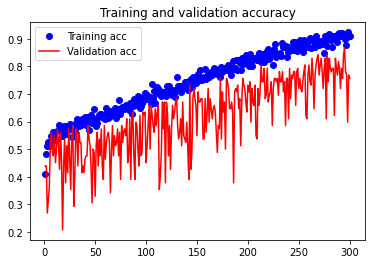

Anstieg der Genauigkeit über die Epochen



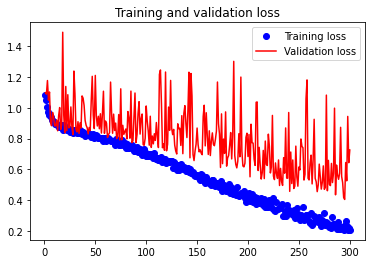

Abnahme des Fehlers über die Epochen



In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color='red')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()
print("Anstieg der Genauigkeit über die Epochen")
print("")

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color='red')
plt.title('Training and validation loss')
plt.legend()
plt.show()
print("Abnahme des Fehlers über die Epochen")
print("")

In [27]:
(test_loss, test_acc) = model.evaluate(test_features, test_labels_bin)
print("Loss: ", test_loss)
print("Accuracy: ", test_acc)

3/3 [==============================] - 0s 5ms/step - loss: 1.2847 - accuracy: 0.6860
Loss:  1.2846691608428955
Accuracy:  0.6860465407371521


### **Vorhersage**

In [28]:
results = model.predict(test_features)

In [29]:
pred = pd.DataFrame({'Pred':(result.argmax() for index, result in enumerate(results)),'True':test_labels.astype('int64')})

pred.head(10)

,Pred,True
27,0,0
363,2,2
63,0,0
382,2,2
236,2,1
410,2,2
219,2,2
358,2,2
271,2,2
417,2,2


In [30]:
pred['True'].value_counts().sort_index()

0    29
1    23
2    34
Name: True, dtype: int64

In [31]:
pred['Pred'].value_counts().sort_index()

0    25
1    14
2    47
Name: Pred, dtype: int64